07.02.23

# Analyse slices annotated by experts

- Open, organise and analyse the slices that have been annotated by the experts.
- Compute some metrics to get inter-observer variability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
#import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd

#from skimage.io import imsave

from in_out_tools import load_movies_ids, load_annotations_ids
from visualization_tools import get_discrete_cmap, get_labels_cmap, get_annotations_contour
from metrics_tools import compute_iou, empty_marginal_frames
from data_processing_tools import get_processed_result, class_to_nb, dict_to_int_mask

## Load slices annotated by experts

In [3]:
#slices_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
slices_ids = ['02', '03', '04', '05', '06', '07', '08', '09', '10']

#expert_ids = ['RJ', 'ME', 'NS', 'EN', 'MW', 'MF', 'CS']
expert_ids = ['RJ', 'ME', 'EN']

dir = r'C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices'

In [4]:
# Load all .tif files and save them in a dictionary
# Dictionary are indexed by the slice id and the expert id
all_segmentations = dict.fromkeys(expert_ids+['ground_truth','unet_preds'])

for expert_id in expert_ids:
    all_segmentations[expert_id] = dict.fromkeys(slices_ids)
    for slice_id in slices_ids:
        all_segmentations[expert_id][slice_id] = imageio.volread(os.path.join(dir, 
                                                                      expert_id, 
                                                                      'sample'+slice_id+'.tif'))

## Load corresponding slices in annotated dataset and UNet predictions

In [5]:
slice_to_movie_id = {'01': '15',
                     '02': '20',
                     '03': '34',
                     '04': '05',
                     '05': '10',
                     '06': '25',
                     '07': '32',
                     '08': '34',
                     '09': '40',
                     '10': '45'}

slice_to_frame_id = {'01': 54-1,
                     '02': 445-1,
                     '03': 430-1,
                     '04': 351-1,
                     '05': 410-1,
                     '06': 109-1,
                     '07': 950-1,
                     '08': 894-1,
                     '09': 898-1,
                     '10': 667-1}

### Load annotated dataset

In [6]:
dataset_dir = os.path.join("..", "data", "sparks_dataset")

In [7]:
all_segmentations['ground_truth'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['ground_truth'][slice_id] = np.asarray(imageio.volread(os.path.join(
                                                    dataset_dir,
                                                    (movie_id+'_class_label.tif'))))[frame_id]

### Load predicted segmentation

In [8]:
movie_ids = ["05","10","15","20","25","32","34","40","45"]

In [9]:
training_name = 'TEMP_new_annotated_peaks_physio'
epoch = 100000

preds_dir = os.path.join("trainings_validation", training_name)

In [10]:
### Load movies
xs = load_movies_ids(data_folder=dataset_dir,
                     ids=movie_ids,
                     names_available=True,
                     movie_names="video")

### Load predictions
sparks_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_waves.tif") for movie_id in movie_ids}

sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [11]:
# parameters necessary to process predictions

# physiological params (for spark peaks results)
pixel_size = 0.2 # 1 pixel = 0.2 um x 0.2 um
min_dist_xy = round(1.8 / pixel_size) # min distance in space
time_frame = 6.8 # 1 frame = 6.8 ms
min_dist_t = round(20 / time_frame) # min distance in time

# spark instances detection parameters
min_dist_xy = min_dist_xy
min_dist_t = min_dist_t
radius = math.ceil(min_dist_xy / 2)
y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
disk = x**2 + y**2 <= radius**2
conn_mask = np.stack([disk] * (min_dist_t), axis=0)

# connectivity for event instances detection
connectivity = 26
sigma = 3

# TODO: use better parameters !!!
pixel_size = 0.2
spark_min_width = 3
spark_min_t = 3
puff_min_t = 5
wave_min_width = round(15 / pixel_size)

# maximal gap between two predicted puffs or waves that belong together
max_gap = 2  # i.e., 2 empty frames

In [12]:
preds_segmentation = {}

for movie_id in movie_ids:
    _, preds, _ = get_processed_result(
            sparks=sparks[movie_id],
            puffs=puffs[movie_id],
            waves=waves[movie_id],
            xs=xs[movie_id],
            conn_mask=conn_mask,
            connectivity=connectivity,
            max_gap=max_gap,
            sigma=sigma,
            wave_min_width=wave_min_width,
            puff_min_t=puff_min_t,
            spark_min_t=spark_min_t,
            spark_min_width=spark_min_width,
        )
    preds_segmentation[movie_id] = dict_to_int_mask(preds)

In [13]:
all_segmentations['unet_preds'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['unet_preds'][slice_id] = preds_segmentation[movie_id][frame_id]

In [14]:
for slice_id in slices_ids:
    for annotator in all_segmentations.keys():
        print(f"Slice {slice_id} - {annotator}: {np.unique(all_segmentations[annotator][slice_id])}")

Slice 02 - RJ: [0 1 3]
Slice 02 - ME: [0 1 3]
Slice 02 - EN: [0 1 2]
Slice 02 - ground_truth: [0 3]
Slice 02 - unet_preds: [0 1]
Slice 03 - RJ: [0 1]
Slice 03 - ME: [0 1 3]
Slice 03 - EN: [0 1 3]
Slice 03 - ground_truth: [0 1 2]
Slice 03 - unet_preds: [0 1 3]
Slice 04 - RJ: [0 1 3]
Slice 04 - ME: [0 1 3]
Slice 04 - EN: [0 1 3]
Slice 04 - ground_truth: [0 1 3]
Slice 04 - unet_preds: [0 1 3]
Slice 05 - RJ: [0 3]
Slice 05 - ME: [0 3]
Slice 05 - EN: [0 2 3]
Slice 05 - ground_truth: [0 1 3]
Slice 05 - unet_preds: [0 1 3]
Slice 06 - RJ: [0 1]
Slice 06 - ME: [0 1]
Slice 06 - EN: [0]
Slice 06 - ground_truth: [0 1 3]
Slice 06 - unet_preds: [0 1 3]
Slice 07 - RJ: [0 1]
Slice 07 - ME: [0 1]
Slice 07 - EN: [0]
Slice 07 - ground_truth: [0 1 3]
Slice 07 - unet_preds: [0 1 3]
Slice 08 - RJ: [0 1 2 3]
Slice 08 - ME: [0 1 3]
Slice 08 - EN: [0 1 2]
Slice 08 - ground_truth: [0 1 2]
Slice 08 - unet_preds: [0 1 3]
Slice 09 - RJ: [0 1 2]
Slice 09 - ME: [0 2 3]
Slice 09 - EN: [0 2]
Slice 09 - ground_truth: [

In [15]:
from sklearn.metrics import cohen_kappa_score

In [27]:
# for each slice ID, compute inter-annotator agreement and store results in a dataframe
kappa_list = []
for slice_id in slices_ids:
    for annotator_1 in all_segmentations.keys():
        for annotator_2 in all_segmentations.keys():
            if annotator_1 != annotator_2:
                kappa_list.append({'slice_id': slice_id,
                                'annotator_1': annotator_1,
                                'annotator_2': annotator_2,
                                'kappa': cohen_kappa_score(all_segmentations[annotator_1][slice_id].flatten(), 
                                                           all_segmentations[annotator_2][slice_id].flatten())})

kappa_df = pd.DataFrame(kappa_list)

In [28]:
kappa_df

,slice_id,annotator_1,annotator_2,kappa
0,02,RJ,ME,0.545308
1,02,RJ,EN,0.328682
2,02,RJ,ground_truth,0.445219
3,02,RJ,unet_preds,0.092363
4,02,ME,RJ,0.545308
...,...,...,...,...
175,10,ground_truth,unet_preds,0.492566
176,10,unet_preds,RJ,0.846492
177,10,unet_preds,ME,0.577495
178,10,unet_preds,EN,0.854686


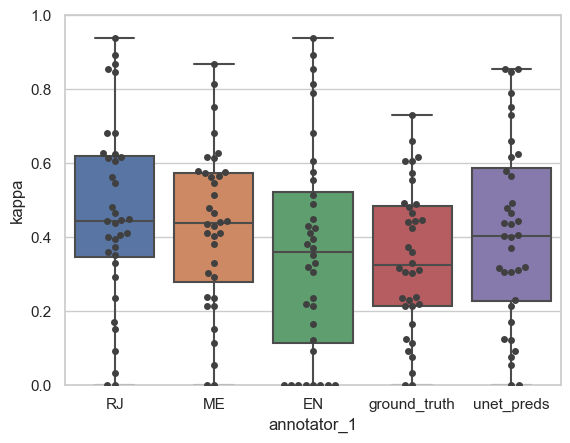

In [29]:
# visualize kappa values
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="annotator_1", y="kappa", data=kappa_df)
ax = sns.swarmplot(x="annotator_1", y="kappa", data=kappa_df, color=".25")
ax.set_ylim(0, 1)
plt.show()


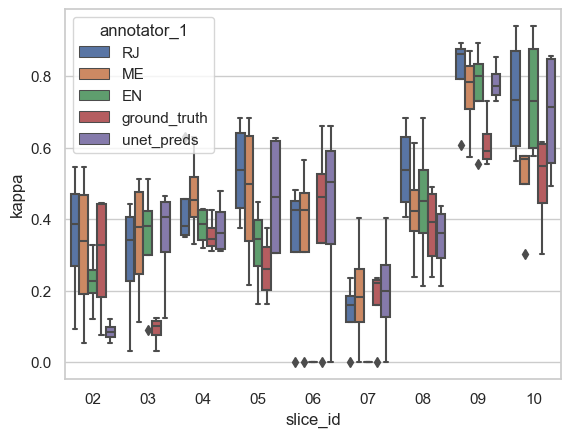

In [30]:
# visualize kappa values for each slice
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="slice_id", y="kappa", hue="annotator_1", data=kappa_df)

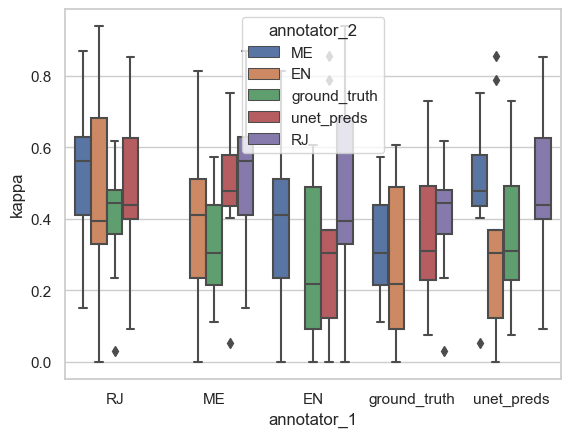

In [31]:
# visualize kappa values for each annotator
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="annotator_1", y="kappa", hue="annotator_2", data=kappa_df)

<AxesSubplot: xlabel='annotator_2', ylabel='annotator_1'>

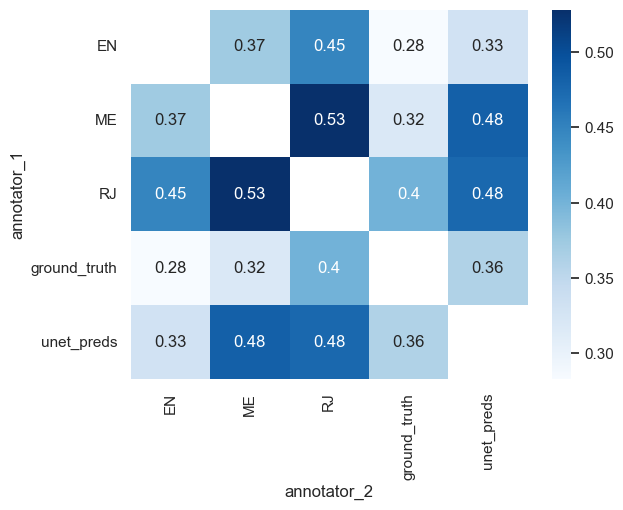

In [32]:
# compute average kappa values over all slices and plot heatmap
avg_kappa_df = kappa_df.pivot_table(index='annotator_1', columns='annotator_2', values='kappa', aggfunc='mean')
sns.heatmap(avg_kappa_df, annot=True, cmap='Blues')

In [33]:
# compute inter-annotator agreement using a different metric
from sklearn.metrics import adjusted_rand_score
rand_list = []
for slice_id in slices_ids:
    for annotator_1 in all_segmentations.keys():
        for annotator_2 in all_segmentations.keys():
            if annotator_1 != annotator_2:
                rand_list.append({'slice_id': slice_id,
                                'annotator_1': annotator_1,
                                'annotator_2': annotator_2,
                                'rand': adjusted_rand_score(all_segmentations[annotator_1][slice_id].flatten(), 
                                                           all_segmentations[annotator_2][slice_id].flatten())})

rand_df = pd.DataFrame(rand_list)

<AxesSubplot: xlabel='annotator_2', ylabel='annotator_1'>

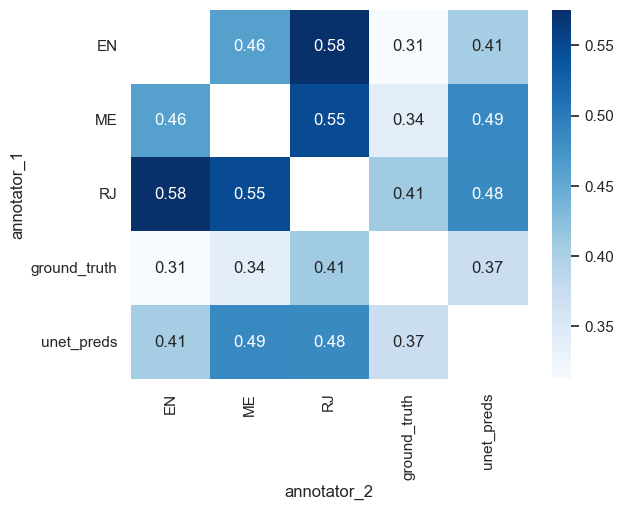

In [36]:
# compute average rand values over all slices and plot heatmap
avg_rand_df = rand_df.pivot_table(index='annotator_1', columns='annotator_2', values='rand', aggfunc='mean')
sns.heatmap(avg_rand_df, annot=True, cmap='Blues')